In [1]:
import seaborn
import librosa
import numpy as np


CONTENT_FILENAME = "inputs/treasure_10.mp3"
audio_filename = CONTENT_FILENAME
#audio_filename = './data/369148__flying-deer-fx__music-box-the-flea-waltz.wav'

#sr = 8000
y, sr = librosa.load(audio_filename, sr=None, mono=True)
print y.shape

min_y = np.min(y)
max_y = np.max(y)

# normalize
y = (y - min_y) / (max_y - min_y)
print y.dtype, min_y, max_y

from IPython.display import Audio
Audio(y, rate=sr)

(441000,)
float32 -1.0 0.9999695


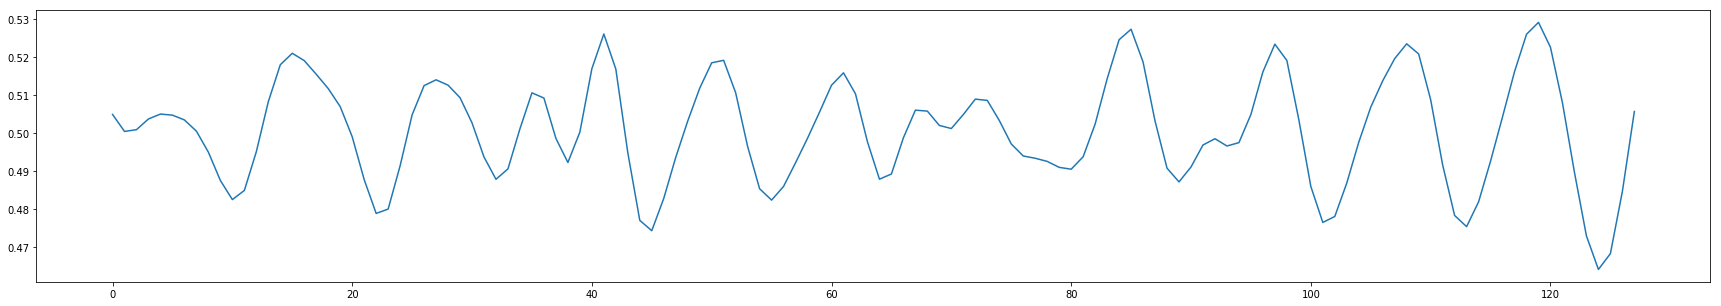

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(30,5))
plt.plot(y[20000:20128].transpose())
plt.show()

In [3]:
# Build a model
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Dropout
from keras.layers import LSTM
from keras.layers import Input
from keras.optimizers import RMSprop
import tensorflow as tf

# so try to estimate next sample afte given (maxlen) samples
#maxlen     = 128 # 128 / sr = 0.016 sec
maxlen = 128
nb_output = 256  # resolution - 8bit encoding
latent_dim = 128

inputs = Input(shape=(maxlen, nb_output))
x = LSTM(latent_dim, return_sequences=True)(inputs)
x = Dropout(0.4)(x)
x = LSTM(latent_dim)(x)
x = Dropout(0.4)(x)
output = Dense(nb_output, activation='softmax')(x)
model = Model(inputs, output)

#optimizer = Adam(lr=0.005)
optimizer = RMSprop(lr=0.01) 
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

In [4]:
from tqdm import tqdm

# try to estimate next_sample (0 -255) based on 256 previous samples 
step = 5
next_sample = []
samples = []
for j in tqdm(range(0, y.shape[0] - maxlen, step)):
    seq = y[j: j + maxlen + 1]  
    seq_matrix = np.zeros((maxlen, nb_output), dtype=bool) 
    for i,s in enumerate(seq):
        sample_ = int(s * (nb_output - 1)) # 0-255
        if i < maxlen:
            seq_matrix[i, sample_] = True
        else:
            seq_vec = np.zeros(nb_output, dtype=bool)
            seq_vec[sample_] = True
            next_sample.append(seq_vec)
    samples.append(seq_matrix)
samples = np.array(samples, dtype=bool)
next_sample = np.array(next_sample, dtype=bool)
print samples.shape, next_sample.shape

100%|██████████| 88175/88175 [00:38<00:00, 2305.13it/s]


(88175, 128, 256) (88175, 256)


In [6]:
from keras.callbacks import EarlyStopping, CSVLogger, ModelCheckpoint
csv_logger = CSVLogger('training_audio.log')
escb = EarlyStopping(monitor='val_loss', patience=20, verbose=1)
checkpoint = ModelCheckpoint("models/audio-{epoch:02d}-{val_loss:.2f}.hdf5", monitor='val_loss', verbose=1, period=2)

model.fit(samples, next_sample, shuffle=True, batch_size=256, verbose=1, #initial_epoch=50,
          validation_split=0.1, nb_epoch=500, callbacks=[csv_logger, escb, checkpoint])

/home/agatha/miniconda3/envs/ee298z/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  import sys


Train on 79357 samples, validate on 8818 samples
Epoch 1/500
79357/79357 [==============================] - 91s 1ms/step - loss: 2.1456 - val_loss: 2.8634
Epoch 2/500
79357/79357 [==============================] - 91s 1ms/step - loss: 2.0776 - val_loss: 2.8048

Epoch 00002: saving model to models/audio-02-2.80.hdf5
Epoch 3/500
79357/79357 [==============================] - 91s 1ms/step - loss: 2.0462 - val_loss: 2.7602
Epoch 4/500
79357/79357 [==============================] - 91s 1ms/step - loss: 2.0149 - val_loss: 2.7455

Epoch 00004: saving model to models/audio-04-2.75.hdf5
Epoch 5/500
79357/79357 [==============================] - 92s 1ms/step - loss: 2.0127 - val_loss: 2.8693
Epoch 6/500
79357/79357 [==============================] - 91s 1ms/step - loss: 2.2311 - val_loss: 2.7231

Epoch 00006: saving model to models/audio-06-2.72.hdf5
Epoch 7/500
79357/79357 [==============================] - 92s 1ms/step - loss: 1.9719 - val_loss: 2.6849
Epoch 8/500
79357/79357 [================

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

print "Training history"
fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(1, 2, 1)
plt.plot(model.history.history['loss'])
ax1.set_title('loss')
ax2 = fig.add_subplot(1, 2, 2)
plt.plot(model.history.history['val_loss'])
ax2.set_title('validation loss')

SyntaxError: Missing parentheses in call to 'print'. Did you mean print("Training history")? (<ipython-input-7-228ffa1acf28>, line 4)

  8%|▊         | 413/5000 [00:35<06:36, 11.55it/s]/home/agatha/miniconda3/envs/ee298z/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys
100%|██████████| 5000/5000 [07:09<00:00, 11.64it/s]


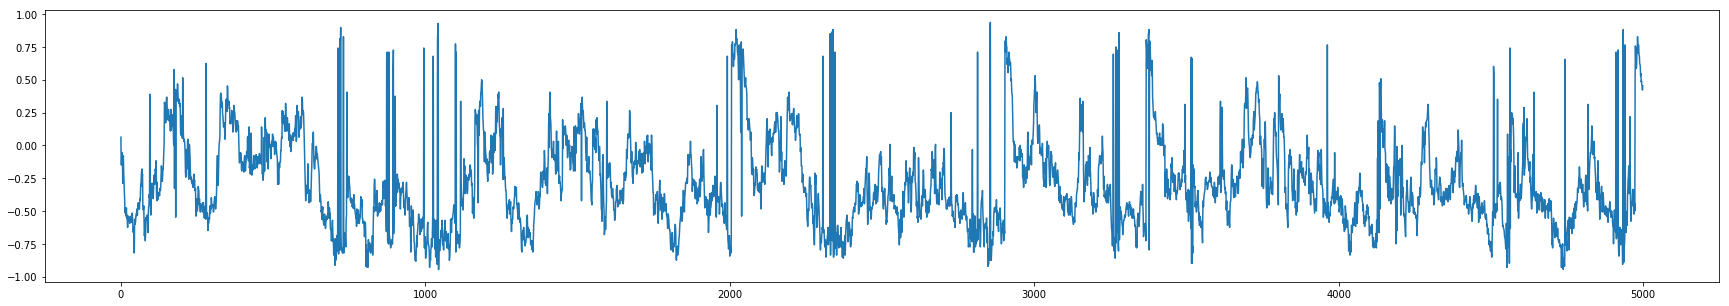

100%|██████████| 5000/5000 [07:09<00:00, 11.65it/s]


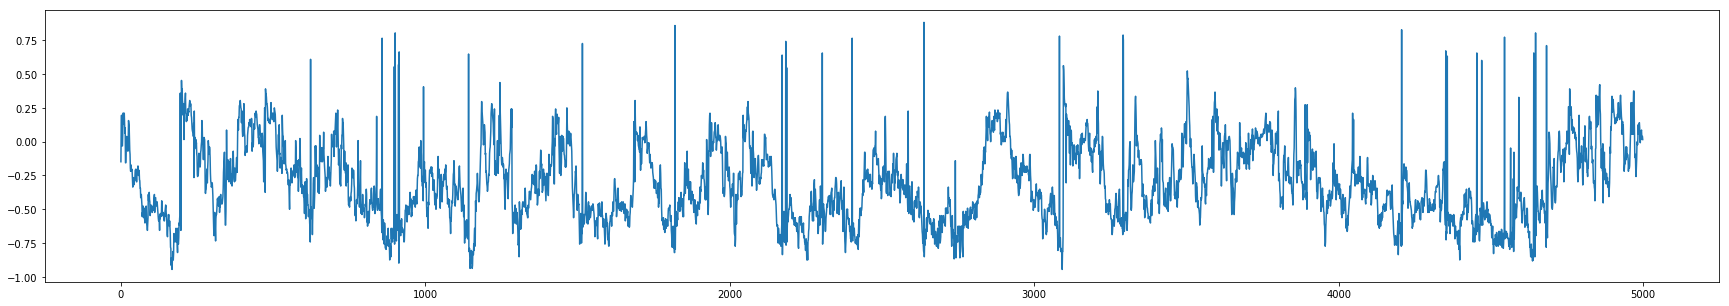

100%|██████████| 5000/5000 [07:07<00:00, 12.04it/s]


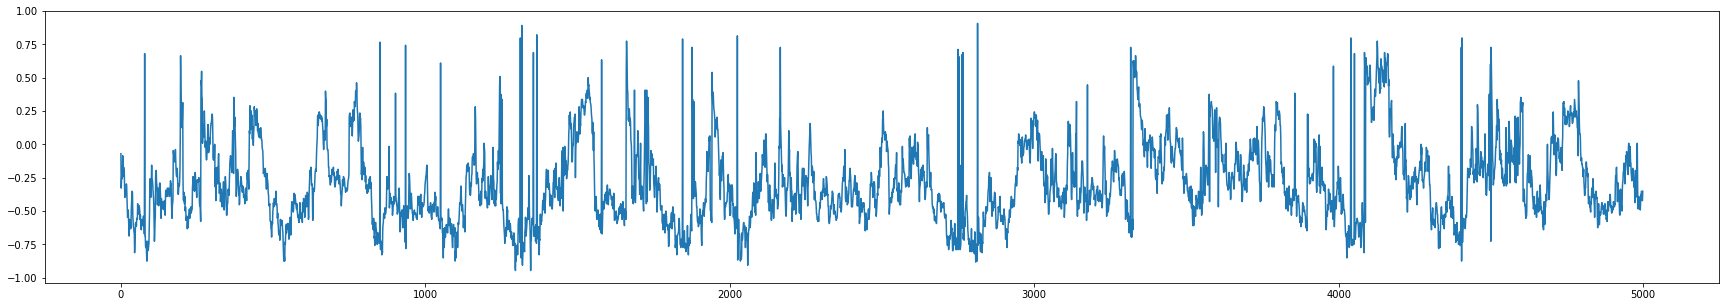

100%|██████████| 5000/5000 [07:08<00:00, 12.36it/s]


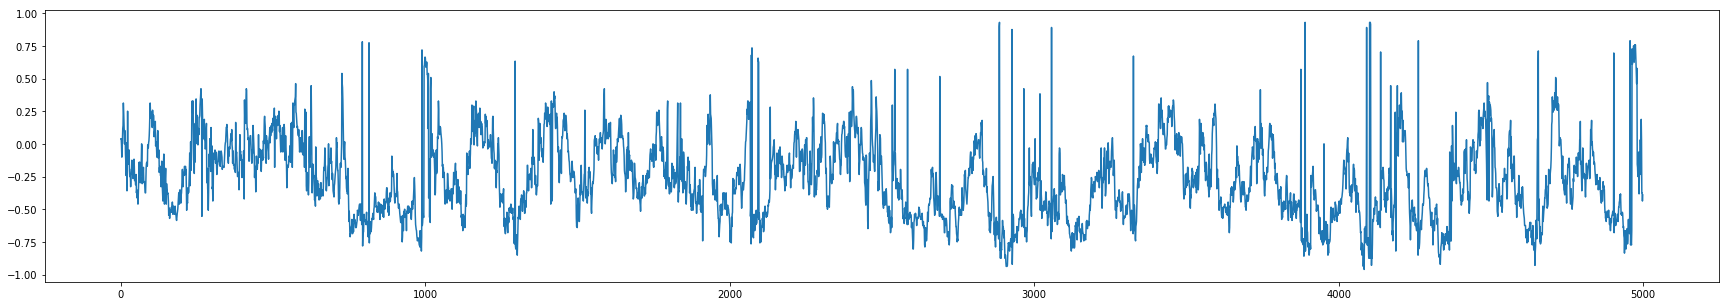

100%|██████████| 5000/5000 [07:28<00:00, 10.78it/s]


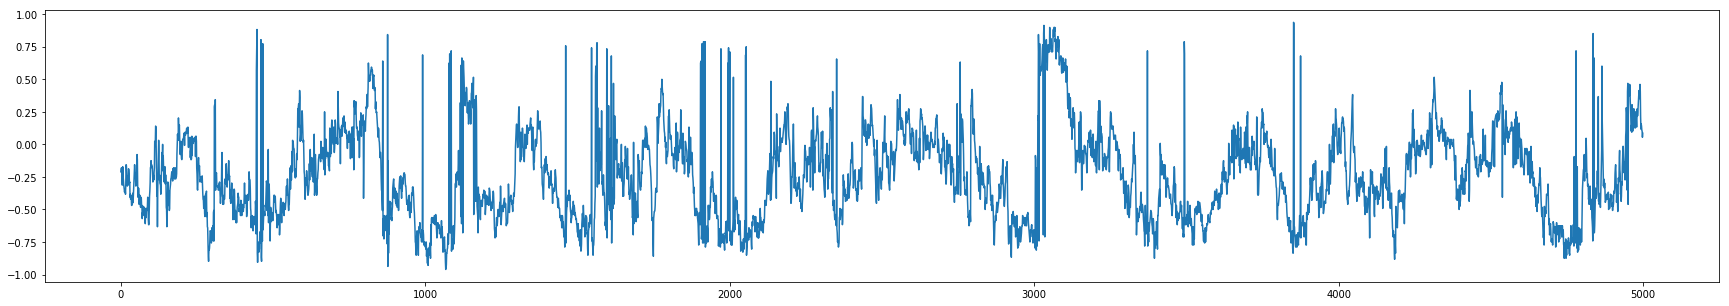

100%|██████████| 5000/5000 [07:20<00:00, 11.48it/s]


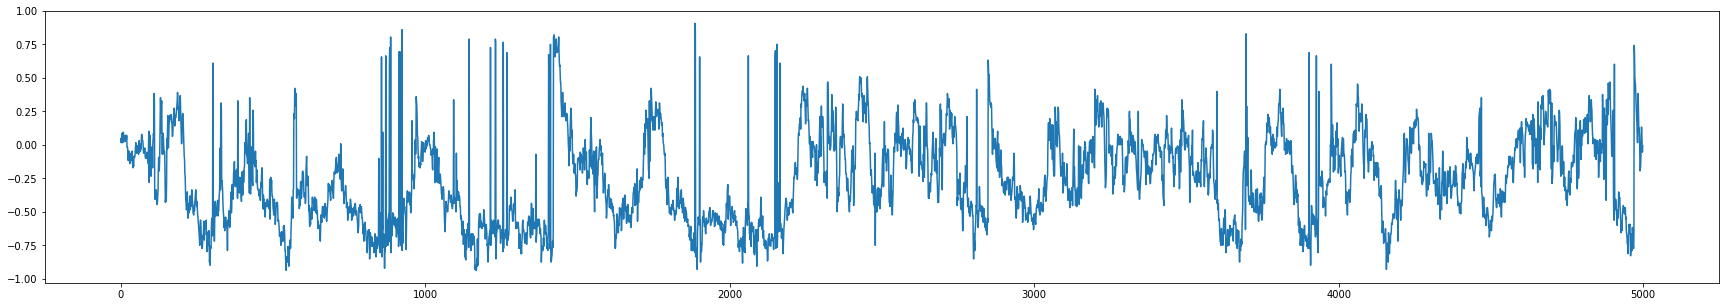

100%|██████████| 5000/5000 [07:12<00:00, 11.23it/s]


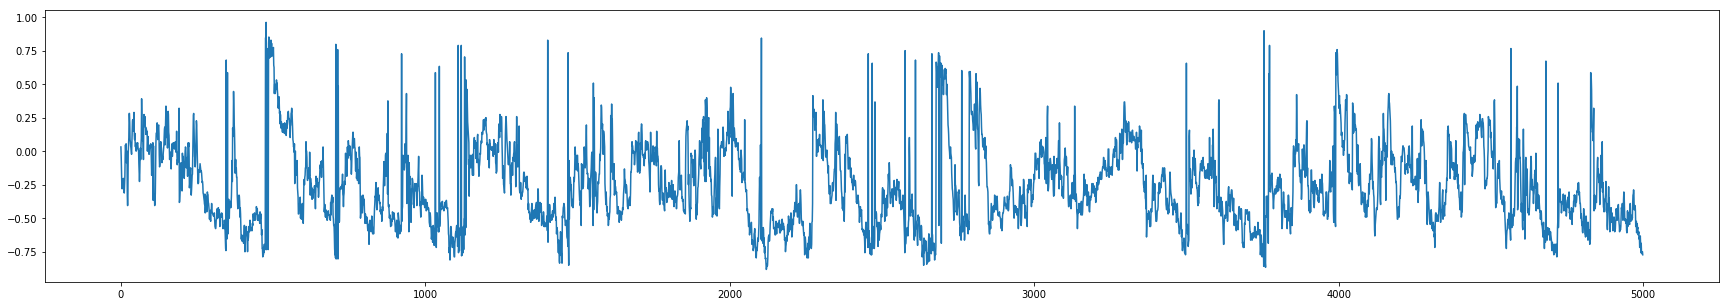

100%|██████████| 5000/5000 [07:13<00:00, 11.99it/s]


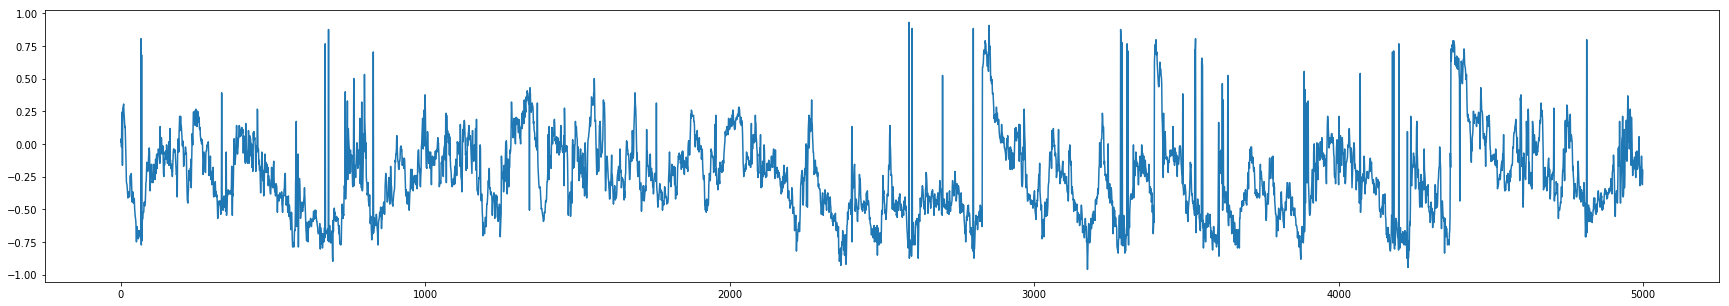

100%|██████████| 5000/5000 [07:17<00:00, 11.61it/s]


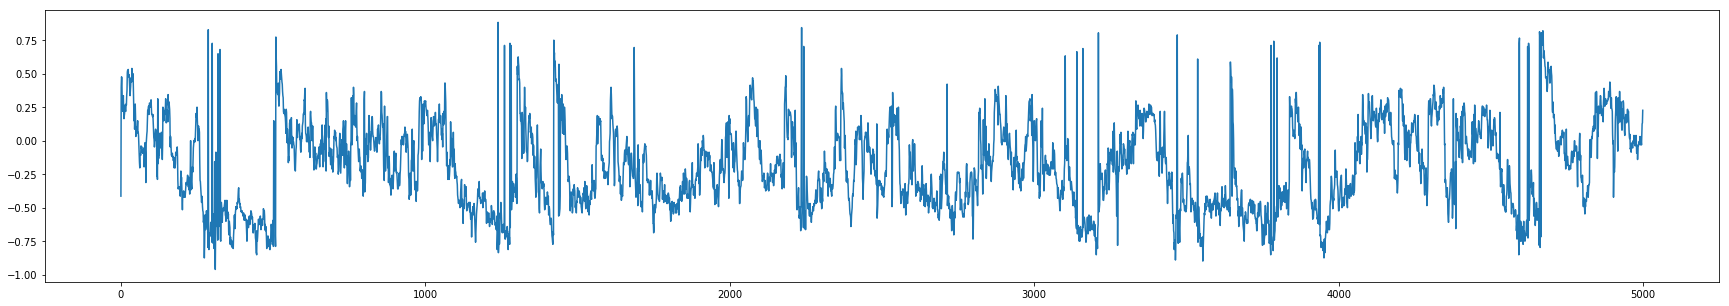

100%|██████████| 5000/5000 [07:04<00:00, 11.59it/s]


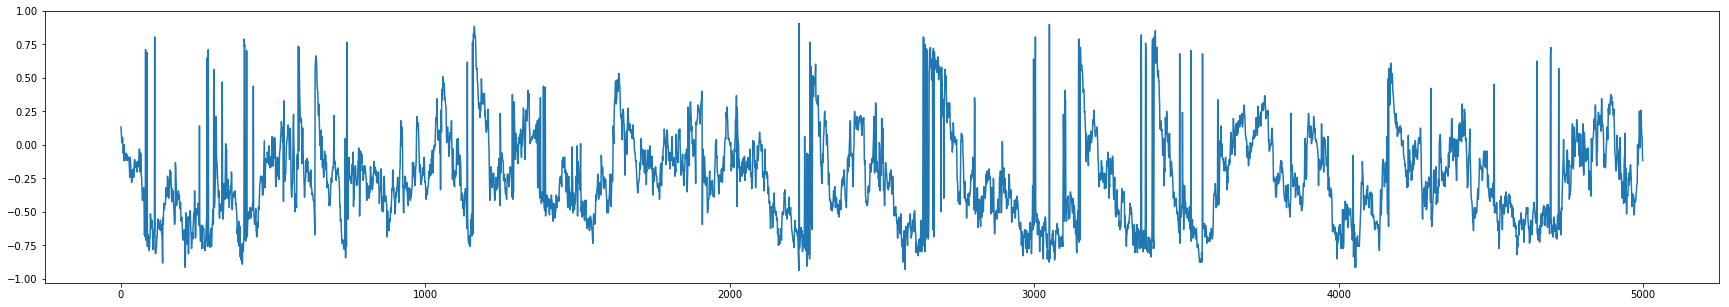

100%|██████████| 5000/5000 [07:03<00:00, 12.01it/s]


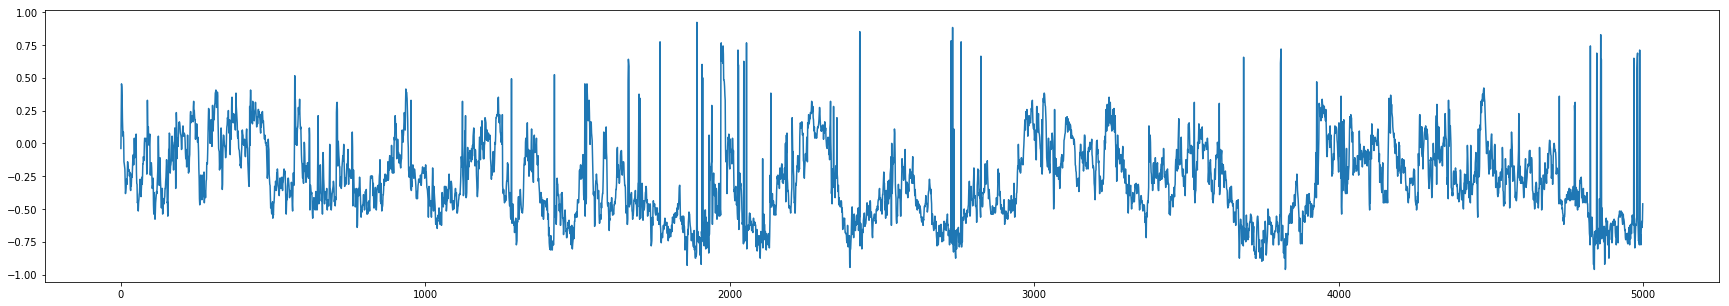

100%|██████████| 5000/5000 [07:03<00:00, 11.93it/s]


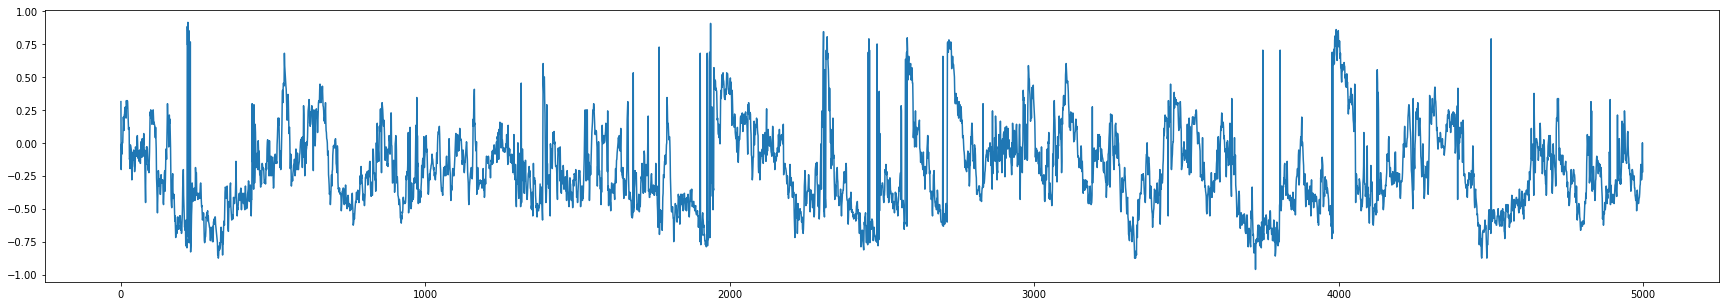

100%|██████████| 5000/5000 [07:04<00:00, 11.93it/s]


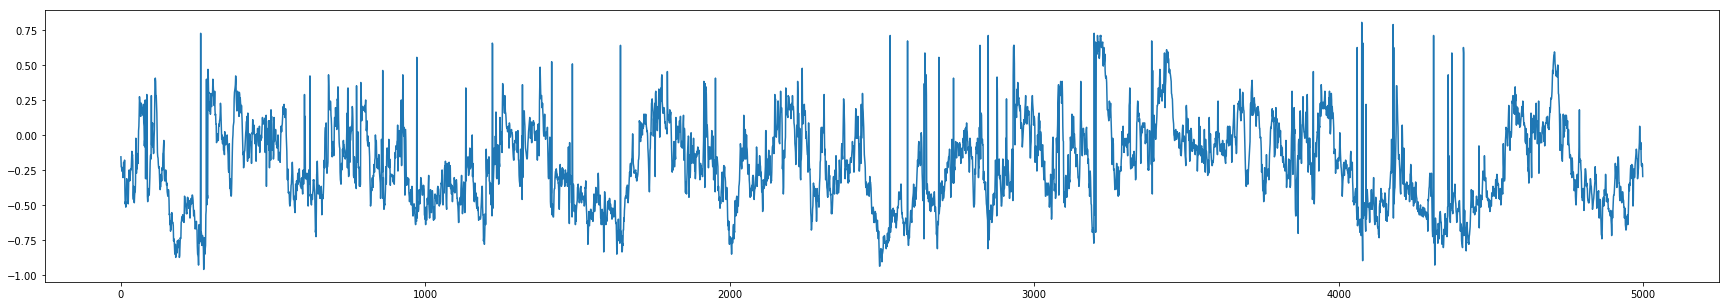

100%|██████████| 5000/5000 [07:04<00:00, 12.32it/s]


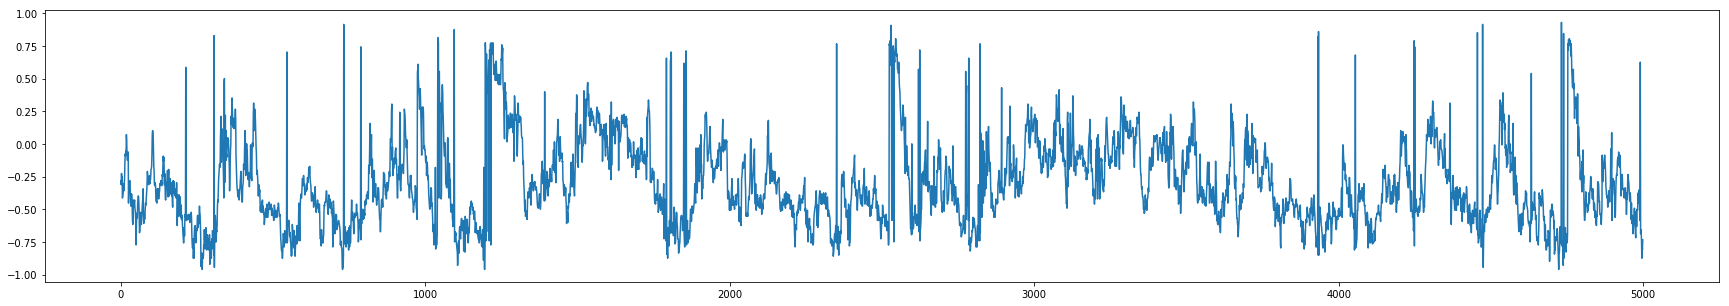

100%|██████████| 5000/5000 [07:03<00:00, 11.57it/s]


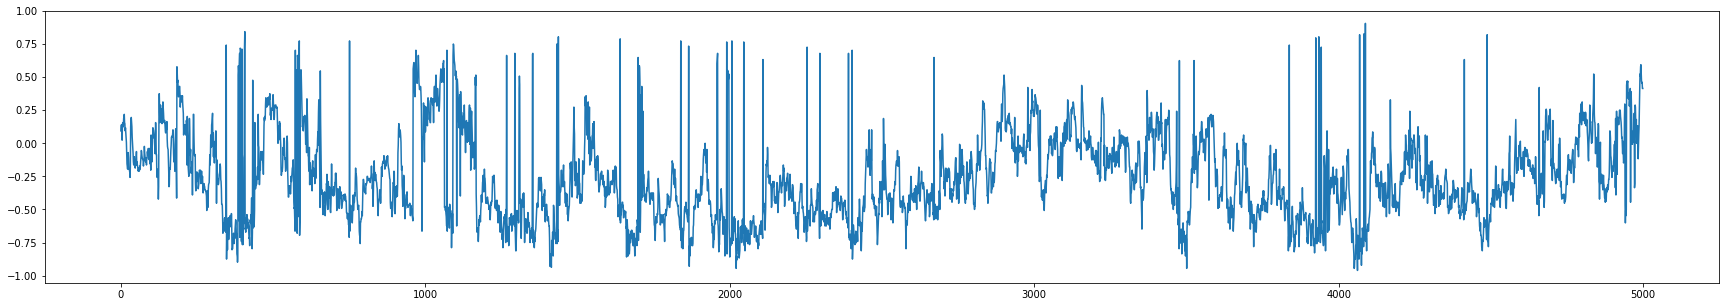

100%|██████████| 5000/5000 [07:03<00:00, 11.63it/s]


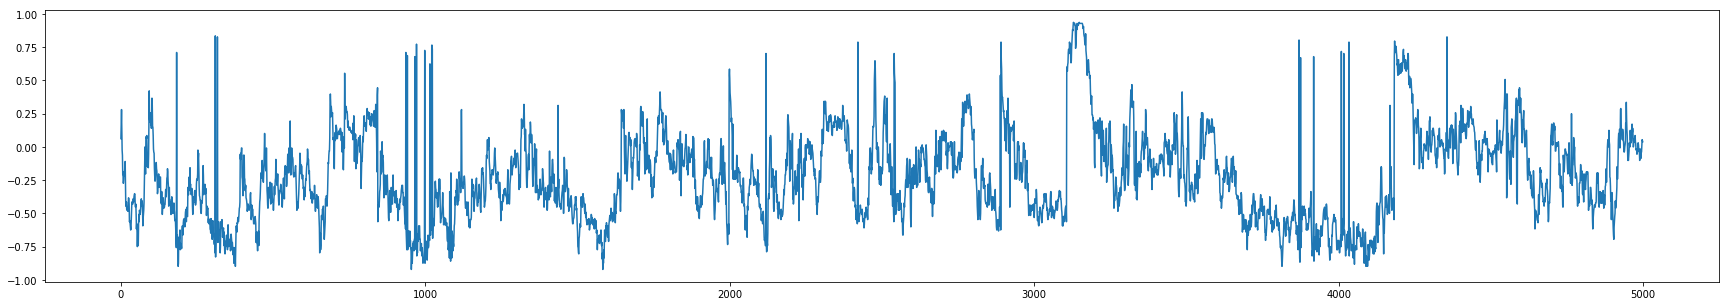

100%|██████████| 5000/5000 [07:02<00:00, 11.58it/s]


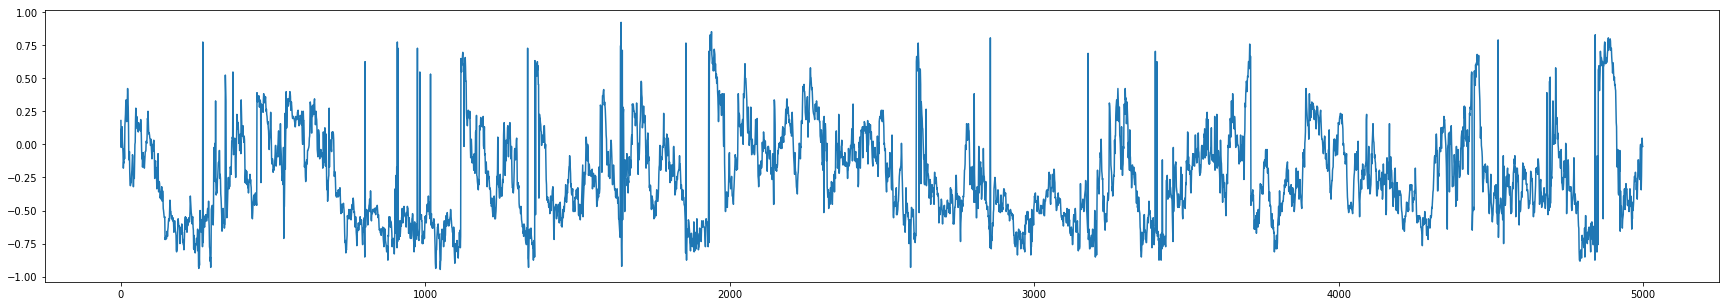

100%|██████████| 5000/5000 [07:03<00:00, 11.82it/s]


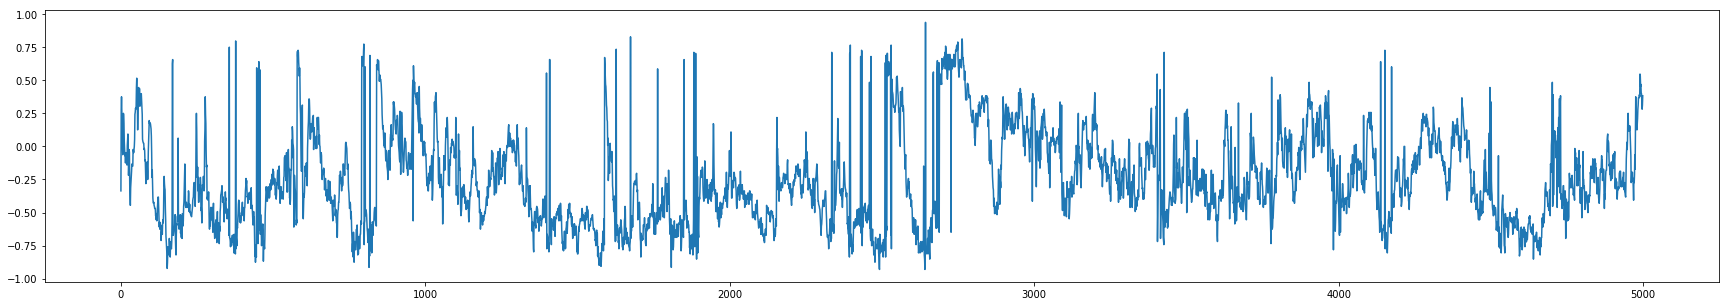

100%|██████████| 5000/5000 [07:03<00:00, 11.64it/s]


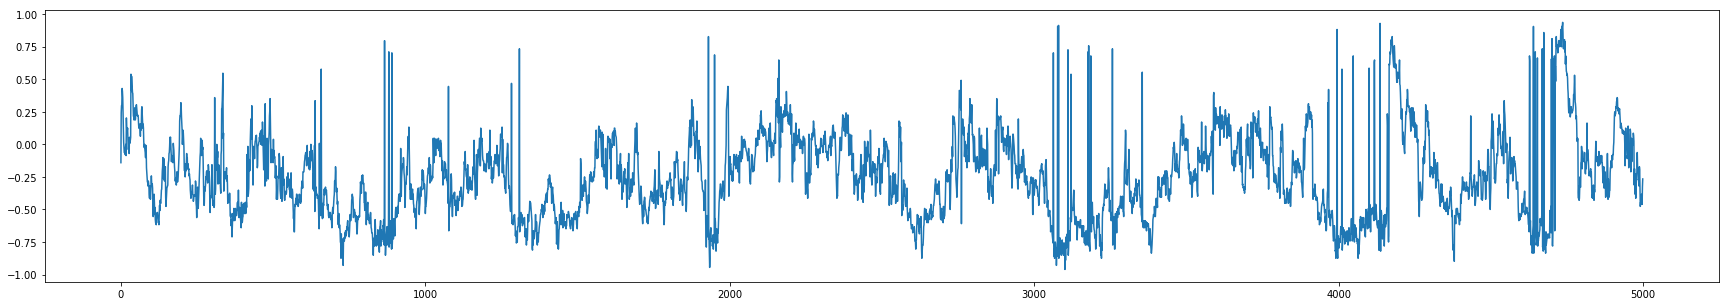

100%|██████████| 5000/5000 [07:04<00:00, 11.53it/s]


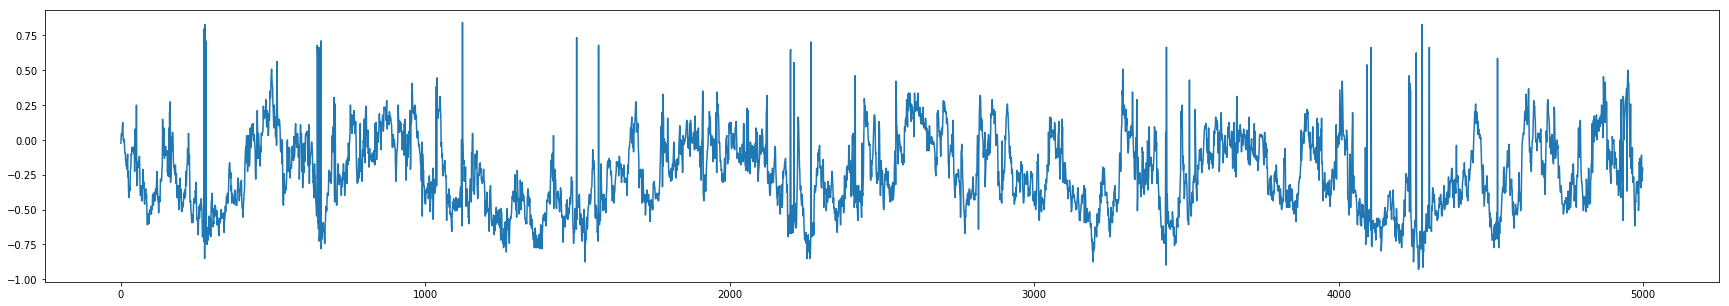

100%|██████████| 5000/5000 [07:03<00:00, 11.80it/s]


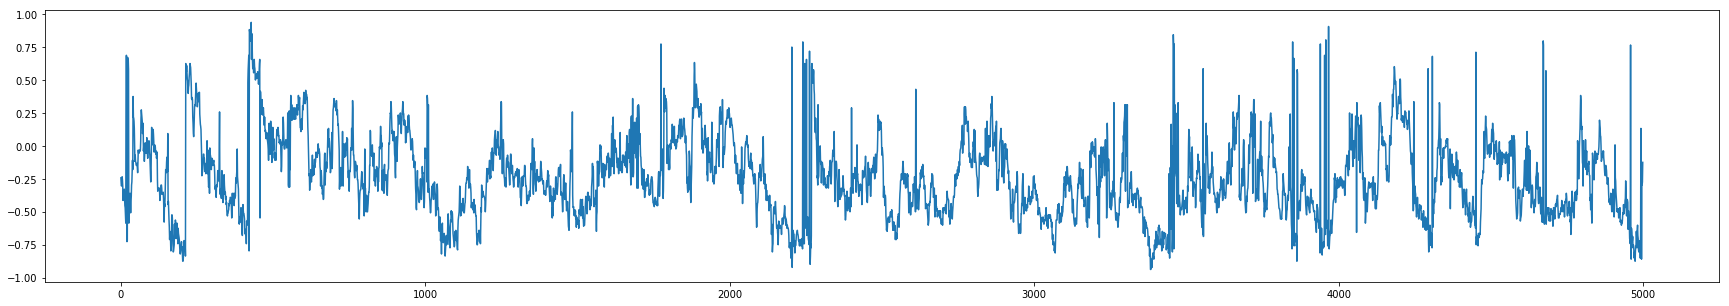

100%|██████████| 5000/5000 [07:03<00:00, 11.80it/s]


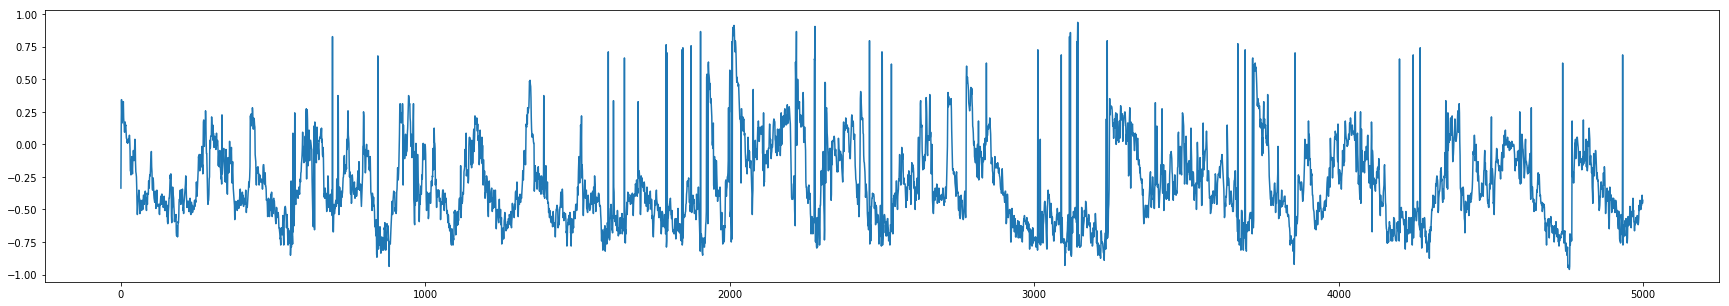

In [8]:
# load array to audio buffer and play!!
from IPython.display import Audio, display
    
def sample(preds, temperature=1.0, min_value=0, max_value=1):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    v = np.argmax(probas)/float(probas.shape[1])
    return v * (max_value - min_value) + min_value
     
for start in range(5000,220000,10000):
    seq = y[start: maxlen]  
    seq_matrix = np.zeros((maxlen, nb_output), dtype=bool) 
    for i,s in enumerate(seq):
        sample_ = int(s * (nb_output - 1)) # 0-255
        seq_matrix[i, sample_] = True

    for i in tqdm(range(5000)):
        z = model.predict(seq_matrix.reshape((1,maxlen,nb_output)))
        s = sample(z[0], 1.0)
        seq = np.append(seq, s)

        sample_ = int(s * (nb_output - 1))    
        seq_vec = np.zeros(nb_output, dtype=bool)
        seq_vec[sample_] = True

        seq_matrix = np.vstack((seq_matrix, seq_vec))  # added generated note info 
        seq_matrix = seq_matrix[1:]
        
    # scale back 
    seq = seq * (max_y - min_y) + min_y

    # plot
    plt.figure(figsize=(30,5))
    plt.plot(seq.transpose())
    plt.show()
    
    display(Audio(seq, rate=sr))

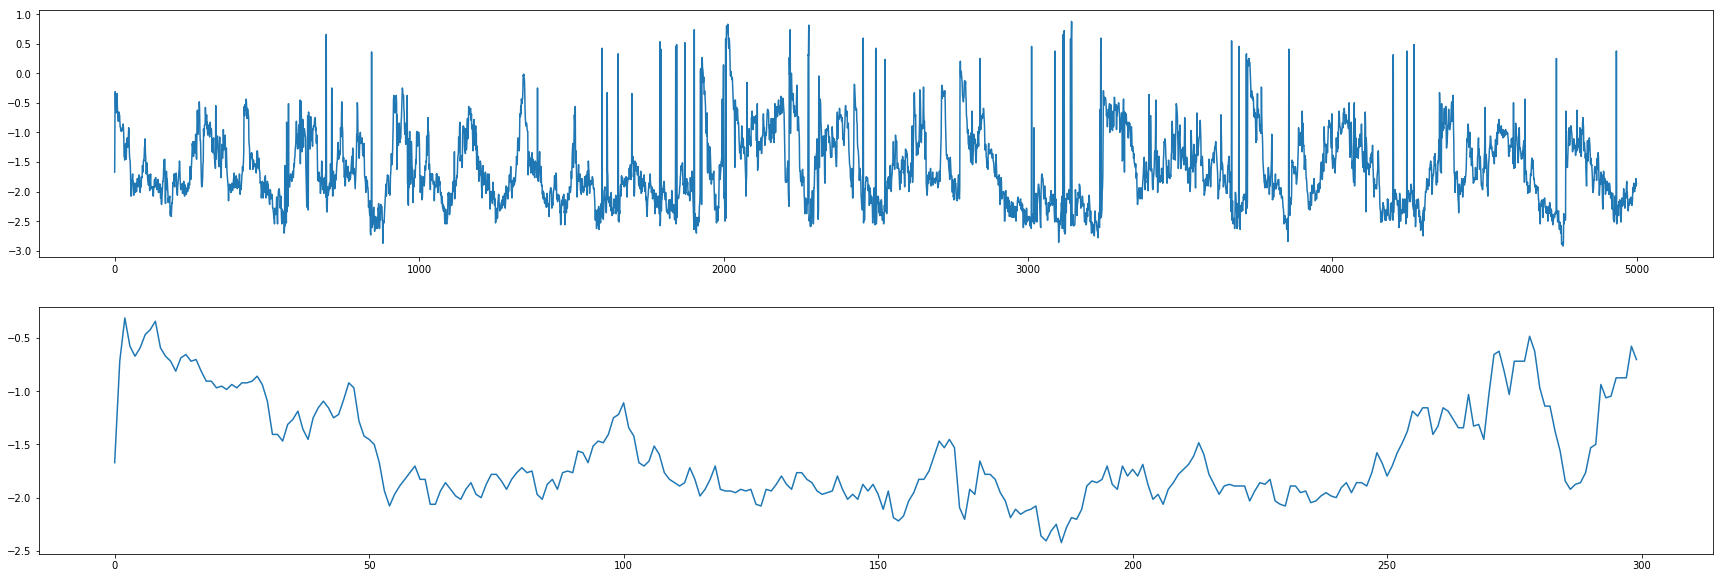

In [9]:
# scale back 
seq = seq * (max_y - min_y) + min_y

# plot
fig = plt.figure(figsize=(30,10))
ax1 = fig.add_subplot(2, 1, 1)
plt.plot(seq.transpose())

ax2 = fig.add_subplot(2, 1, 2)
plt.plot(seq[:300].transpose())
plt.show()

# load array to audio buffer and play!!
from IPython.display import Audio, display
display(Audio(seq, rate=sr))